In [224]:
import pickle
import torch
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [225]:
def load_pickle(filename: str):
    with open(filename, "rb") as outp:
        obj = pickle.load(outp)
    return obj

# Capping analysis
## simexp with ViT

In our experiments we need to cap embeddings back to a 'permissible' range of values. However, when should we perform this capping?

In this notebook I try to understand the differences between:

1. capping the embeddings at **exploration time** (at each simec/simexp iteration, bringing the modified embeddings back to the permissible range)

2. letting the exploration go wherever it goes, and capping embedding only for visualisation purposes: this would be an **interpretation time** capping

### Analysing the difference between the **exploration time** and **intepretation time** approaches

1. How far can we go in terms of exploration with the two approaches?
    - plotting delta values at each iteration;
    - plotting embedding variation (difference) from one iteration to the other, and from all iteration to the original embedding.

2. How are prediction affected?
    - compare prediction values before translating the embedding back to the input space and after (`pred` and `modified_image_pred` in the images case);
    - in the same way, comparing prediction probabilites.

3. How is the translation back to the input space differing?
    - compare the decoded embeddings (images, in case of ViT experiments) produced by the two approaches.

## 1. Exploration distance

### Plotting delta values at each iteration

In [226]:
exploration_capping_experiment_path = "res/exploration-capping/input-space-exploration/simexp-vit-capping-20241028-172812/"
interpretation_capping_experiment_path = (
    "res/interpretation-capping/input-space-exploration/simexp-vit-20241028-171517/"
)

In [227]:
def collect_pkl_res_files(experiment_path: str):
    paths = []
    for input_example_dir in os.listdir(experiment_path):
        if os.path.isdir(os.path.join(experiment_path, input_example_dir)):
            for filename in os.listdir(
                os.path.join(experiment_path, input_example_dir)
            ):
                if os.path.isfile(
                    os.path.join(experiment_path, input_example_dir, filename)
                ) and filename.lower().endswith(".pkl"):
                    paths.append(
                        os.path.join(experiment_path, input_example_dir, filename)
                    )
    return paths

In [228]:
# Initialize dictionary to store experiment results
experiments = {
    "capping": [],
    "input_name": [],
    "iteration": [],
    "distance": [],
    "delta": [],
    "input_embedding": [],
    "output_embedding": [],
}


# Helper function to process a single experiment file and update the results dictionary
def process_experiment_file(file, exp_path, results_dict):
    experiment = load_pickle(file)
    results_dict["capping"].append(exp_path.split("/")[1])
    results_dict["input_name"].append(file.split("/")[-2])
    results_dict["iteration"].append(experiment["iteration"])
    results_dict["distance"].append(experiment["distance"].detach().numpy())
    results_dict["delta"].append(experiment["delta"].detach().numpy().item())
    results_dict["input_embedding"].append(
        experiment["input_embedding"].detach().numpy()
    )
    results_dict["output_embedding"].append(
        experiment["output_embedding"].detach().numpy()
    )


# Loop through experiment paths and files, updating the results dictionary
for exp_path in [
    exploration_capping_experiment_path,
    interpretation_capping_experiment_path,
]:
    for file in collect_pkl_res_files(exp_path):
        process_experiment_file(file, exp_path, experiments)

# Convert to DataFrame
experiments = pd.DataFrame.from_dict(experiments)

In [229]:
experiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   capping           808 non-null    object 
 1   input_name        808 non-null    object 
 2   iteration         808 non-null    int64  
 3   distance          808 non-null    object 
 4   delta             808 non-null    float64
 5   input_embedding   808 non-null    object 
 6   output_embedding  808 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 44.3+ KB


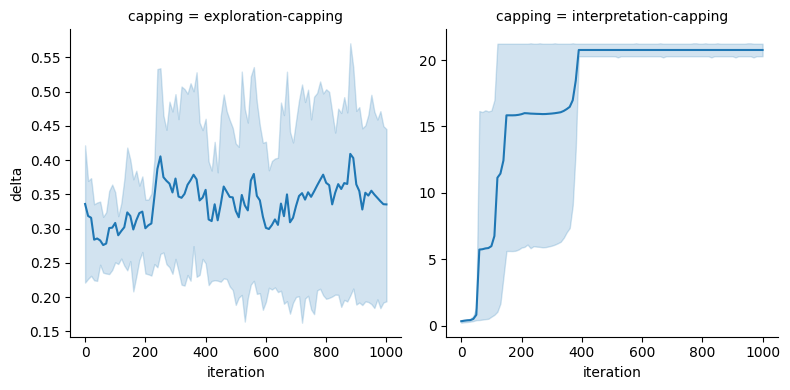

In [230]:
p = sns.FacetGrid(experiments, col="capping", sharey=False, height=4, aspect=1)
p.map(
    sns.lineplot,
    "iteration",
    "delta",
)

<Axes: xlabel='iteration', ylabel='delta'>

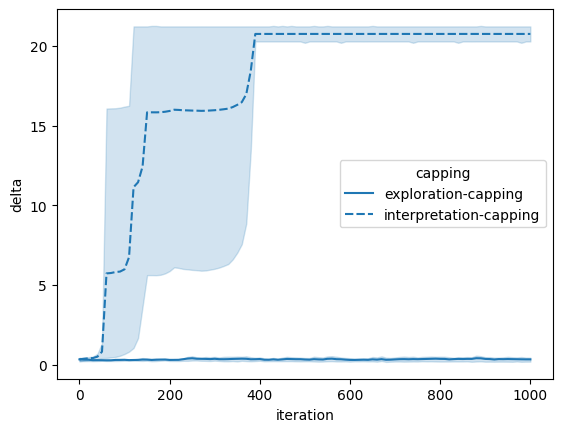

In [231]:
sns.lineplot(data=experiments, x="iteration", y="delta", style="capping")

Delta values vary a lot more when we cap at interpretation time compared to capping at exploration time. This is to be expected. 

But why do we have an increasing value for delta? Why is the step increasing?

### Plotting embedding variation (difference), and from every iteration to the original embedding

In [232]:
experiments["norm-distance"] = experiments.apply(
    lambda x: np.linalg.norm(x["distance"]), axis=1
)

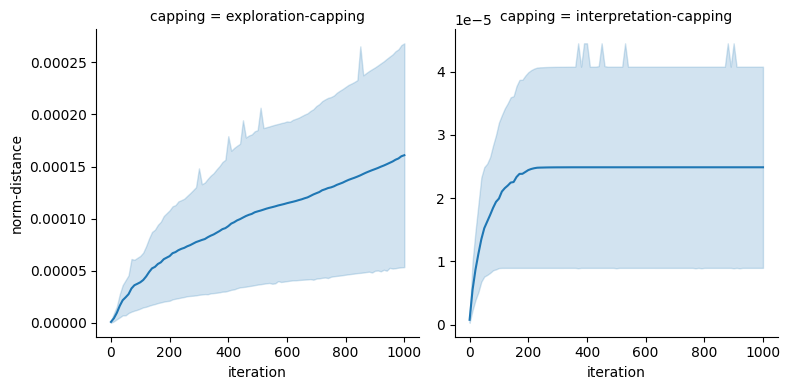

In [233]:
p = sns.FacetGrid(experiments, col="capping", sharey=False, height=4, aspect=1)
p.map(
    sns.lineplot,
    "iteration",
    "norm-distance",
)

Here I am plotting the norm of the distance computed as `distance += eigenvals * delta`. This means that at each iteration, this metric is showing how far the algorithm went with respect to the original embedding.

When the capping procedure is performed during the exploration phase, we can see that the exploration is making the embedding more and more distant from the original embedding.
On the other hand, when performing the capping procedure at interpretation time, we can see that this distance is initially increasing much faster and then it is stabilising at at iteration 200, approximately.

<Axes: xlabel='iteration', ylabel='norm-distance'>

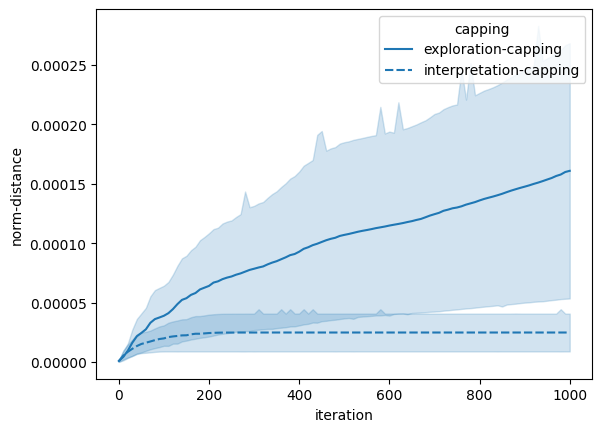

In [234]:
sns.lineplot(data=experiments, x="iteration", y="norm-distance", style="capping")

I find this as a quite strange behaviour, since I would imagine that capping at exploration time would make the algorithm explore less then when capping at interpretation time. However, the norm of the distance is growing and growing in the former scenario, and it is stabilising in the latter scenario. This means that in the former scenario, each iteration add a (constant) amount of distance from the previous iteration.

## 2. Predictions

I aim to analyze whether this modification affects the model's predictions. We have four types of predictions in this analysis:

- **original input instance prediction**: the prediction generated by the model when processing the original input instance.
- **modified embedding prediction**: the prediction generated by the model when processing the embedding modified by the algorithm during an iteration.
- **modified and capped pmbedding prediction**: the prediction generated by the model when processing the updated embedding after it’s been capped, or constrained, to remain within the 'permissible' region.
- **modified input instance prediction**: the prediction generated by the model when processing the decoded version of the modified embedding at each iteration of the algorithm. This decoding step outputs either an image or a text, depending on the task.

For cases where capping is applied at **exploration time**, we directly produce an embedding that remains within the 'permissible' region. Here, we observe two main predictions: **pre-decode**r and **post-decoder** predictions.

For cases where capping is applied at **interpretation time**, we first evaluate the prediction of the non-capped embedding, then the prediction after capping, and finally the prediction after decoding the capped embedding. This results in three relevant predictions: **pre-capping**, **post-capping** and **pre-decoding**, and **post-capping and post-decoding**.

In [238]:
def collect_interpretation_pkl_res_files(experiment_path: str):
    paths = []
    for input_example_dir in os.listdir(experiment_path):
        if os.path.isdir(os.path.join(experiment_path, input_example_dir)):
            if os.path.exists(
                os.path.join(experiment_path, input_example_dir, "interpretation")
            ):
                for pkl_file in os.listdir(
                    os.path.join(experiment_path, input_example_dir, "interpretation")
                ):
                    if os.path.isfile(
                        os.path.join(
                            experiment_path,
                            input_example_dir,
                            "interpretation",
                            pkl_file,
                        )
                    ) and pkl_file.lower().endswith("-stats.pkl"):
                        paths.append(
                            os.path.join(
                                experiment_path,
                                input_example_dir,
                                "interpretation",
                                pkl_file,
                            )
                        )
    return paths

In [239]:
# Helper function to initialize probability columns
def initialize_probability_columns(probas_size):
    return {
        f"{l}_{key}": []
        for l in range(probas_size)
        for key in [
            "prediction-probabilities-from-original-input",
            "prediction-probabilities-from-embedding",
            "prediction-probabilities-from-capped-embedding",
            "prediction-probabilities-from-decoded-capped-embedding",
        ]
    }


# Helper function to update probability values
def update_probability_values(results_dict, interpretation, probas_size):
    for l in range(probas_size):
        results_dict[f"{l}_prediction-probabilities-from-original-input"].append(
            interpretation["original_image_pred_proba"].detach().numpy()[0][l]
        )
        results_dict[
            f"{l}_prediction-probabilities-from-decoded-capped-embedding"
        ].append(interpretation["modified_image_pred_probas"].detach().numpy()[l])

        if interpretation["capped_embedding_pred_proba"] is not None:
            results_dict[f"{l}_prediction-probabilities-from-embedding"].append(
                interpretation["embedding_pred_proba"].detach().numpy()[0][l]
            )
            results_dict[f"{l}_prediction-probabilities-from-capped-embedding"].append(
                interpretation["capped_embedding_pred_proba"].detach().numpy()[0][l]
            )
        else:
            results_dict[f"{l}_prediction-probabilities-from-embedding"].append(None)
            results_dict[f"{l}_prediction-probabilities-from-capped-embedding"].append(
                interpretation["embedding_pred_proba"].detach().numpy()[0][l]
            )


# Initialize main dictionary for results
interpretation_results = {
    "capping": [],
    "input-name": [],
    "iteration": [],
    "prediction-from-original-input": [],
    "prediction-from-embedding": [],
    "prediction-from-capped-embedding": [],
    "prediction-from-decoded-capped-embedding": [],
    "updated-patches": [],
}

# Loop through experiment paths and files
for exp_path in [
    exploration_capping_experiment_path,
    interpretation_capping_experiment_path,
]:
    for file in collect_interpretation_pkl_res_files(exp_path):
        interpretation = load_pickle(file)

        # Update base interpretation results
        interpretation_results["capping"].append(exp_path.split("/")[1])
        interpretation_results["input-name"].append(file.split("/")[-3])
        interpretation_results["iteration"].append(
            int(file.split("/")[-1].split("-")[0])
        )
        interpretation_results["prediction-from-original-input"].append(
            interpretation["original_image_pred"]
        )
        interpretation_results["prediction-from-decoded-capped-embedding"].append(
            interpretation["modified_image_pred"]
        )

        interpretation_results["updated-patches"].append(
            interpretation["modified_patches"].detach().numpy()
        )

        if interpretation["capped_embedding_pred_proba"] is not None:
            interpretation_results["prediction-from-embedding"].append(
                interpretation["embedding_pred"]
            )
            interpretation_results["prediction-from-capped-embedding"].append(
                interpretation["capped_embedding_pred"]
            )
        else:
            interpretation_results["prediction-from-embedding"].append(None)
            interpretation_results["prediction-from-capped-embedding"].append(
                interpretation["embedding_pred"]
            )

        # Initialize probability columns only once
        if len(interpretation_results) == 8:
            probas_size = (
                interpretation["original_image_pred_proba"].detach().numpy().size
            )
            interpretation_results.update(initialize_probability_columns(probas_size))

        # Update probability values
        update_probability_values(interpretation_results, interpretation, probas_size)

# Convert to DataFrame
interpretation_results = pd.DataFrame.from_dict(interpretation_results)

### Prediction change in exploration- and interpretation-time capping

Now I check if and when there is a prediction change in exploration-time versus interpretation-time experiments.

In [240]:
interpretation_results["prediction-change-original-capped"] = (
    interpretation_results["prediction-from-original-input"]
    != interpretation_results["prediction-from-capped-embedding"]
)
interpretation_results["prediction-change-original-decoded"] = (
    interpretation_results["prediction-from-original-input"]
    != interpretation_results["prediction-from-decoded-capped-embedding"]
)

In [241]:
print("Has the (embedding) prediction changed from the original during exploration?")
print(
    interpretation_results.groupby("capping")["prediction-change-original-capped"].sum()
)
print(
    "\n\nHas the (decoded embedding) prediction changed from the original during exploration?"
)
print(
    interpretation_results.groupby("capping")[
        "prediction-change-original-decoded"
    ].sum()
)

Has the (embedding) prediction changed from the original during exploration?
capping
exploration-capping       0
interpretation-capping    0
Name: prediction-change-original-capped, dtype: int64


Has the (decoded embedding) prediction changed from the original during exploration?
capping
exploration-capping       0
interpretation-capping    0
Name: prediction-change-original-decoded, dtype: int64


Let's see how capping at interpretation time can change the prediction: here I compare the prediction from the modified embedding with the prediction from the modified capped embedding.

In [242]:
interpretation_results["prediction-change-notcapped-capped"] = (
    interpretation_results["prediction-from-embedding"]
    != interpretation_results["prediction-from-capped-embedding"]
)
print("Has the prediction changed from edited embedding and capped edited embedding?")
print(
    interpretation_results.groupby("capping")[
        "prediction-change-notcapped-capped"
    ].sum()
)

Has the prediction changed from edited embedding and capped edited embedding?
capping
exploration-capping       404
interpretation-capping     64
Name: prediction-change-notcapped-capped, dtype: int64


Ignoring the number representative for capping at exploration time (which is a sum of NaN values), we can see indeed that capping at interpretation time can result in a change in prediction.

Overall, the intuition here is that capping at exploration time makes the process more 'credible'.

### Probabilities in exploration- and interpretation-time capping

Now that I have checked for prediction changes, I want to have a deeper understanding of how probabilities values in predictions are affected by the capping approach.

In [243]:
def plot_prediction_proba_trend(features: list, classes: list, input_name: str):
    fig, axes = plt.subplots(nrows=len(classes), ncols=len(features), figsize=(15, 30))

    # Create the plots, capturing handles and labels only from the first subplot
    handles, labels = None, None
    for ax_row, label in zip(range(len(axes)), classes):
        for ax_col, feature in zip(range(len(axes[0])), features):
            ax = axes[ax_row][ax_col]

            # Plot the lineplot on each axis
            sns.lineplot(
                data=interpretation_results.loc[
                    interpretation_results["input-name"] == input_name
                ],
                x="iteration",
                y=f"{label}_{feature}",
                style="capping",
                ax=ax,
                legend=(
                    "brief" if handles is None else False
                ),  # Capture legend on the first plot only
            )

            # Remove y-axis labels
            ax.set_ylabel("")

            # Capture handles and labels from the first plot only
            if handles is None and labels is None:
                handles, labels = ax.get_legend_handles_labels()
                ax.get_legend().remove()

            # Set column titles only on the top row
            if ax_row == 0:
                ax.set_title(
                    feature.replace("-", " ").capitalize(),
                    fontsize=12,
                    fontweight="bold",
                )

            # Set row titles only on the first column
            if ax_col == 0:
                ax.annotate(
                    f"Class {label}",
                    xy=(0, 0.5),
                    xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label,
                    textcoords="offset points",
                    size=12,
                    ha="right",
                    va="center",
                    fontweight="bold",
                )

    # Add a single legend for the entire figure using captured handles and labels
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=3,
        title="Capping",
        bbox_to_anchor=(0.2, 0.98),
    )

    # Adjust spacing to reduce the gap
    fig.subplots_adjust(
        top=0.2, hspace=0.4
    )  # `top` controls space above the subplots, `hspace` controls row spacing

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Final layout adjustments
    plt.show()

In [244]:
columns = [
    "prediction-probabilities-from-capped-embedding",
    "prediction-probabilities-from-decoded-capped-embedding",
]
classes = list(range(10))

<img src="/Users/lizzy/research/input-space-inspection/capping-experiments/res/interpretation-capping/input-space-exploration/simexp-vit-20241028-171517/img_18/interpretation/0-7-7-7.png">

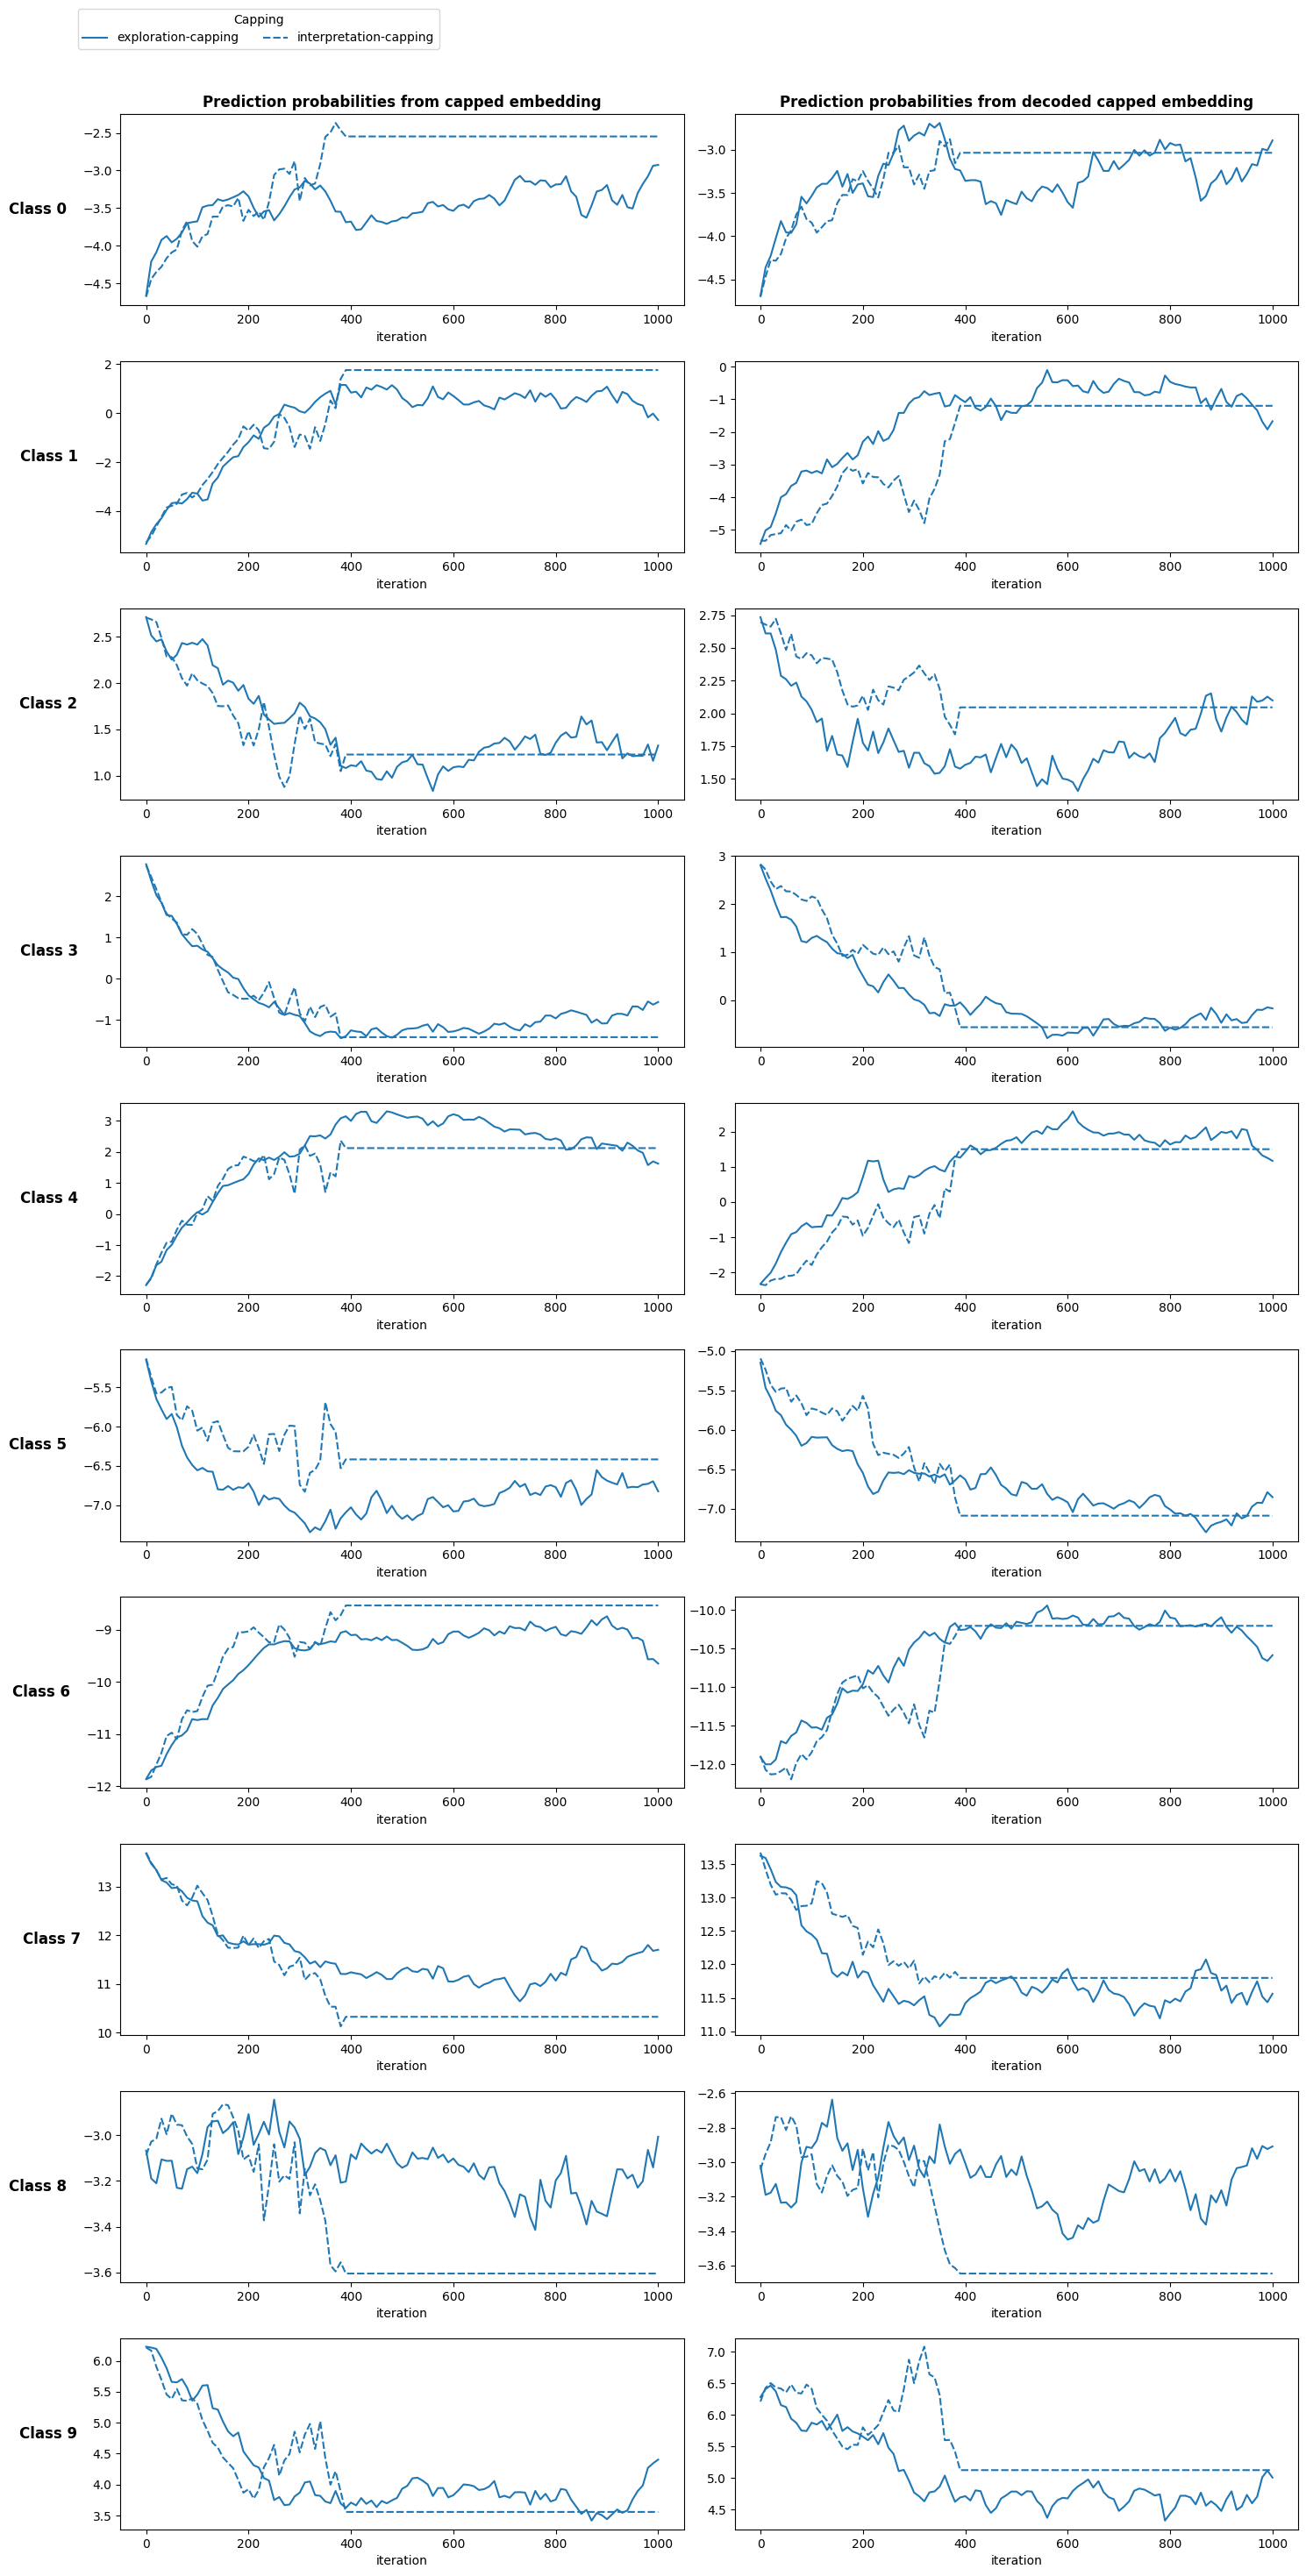

In [245]:
plot_prediction_proba_trend(
    features=columns, classes=list(classes), input_name="img_18"
)

In this initial SimExp experiment using an image of the digit 7, we observe that the probabilities for certain classes are decreasing, while others are increasing. It might be tempting to interpret these probability trends by categorizing them into "golden label" (true class) and "non-true" classes, but this approach could be misleading. The probabilities of non-true classes may either increase or decrease, likely because the transformer model perceives certain classes as similar to each other.

In every of these experiments, there is no prediction change.

<img src="/Users/lizzy/research/input-space-inspection/capping-experiments/res/interpretation-capping/input-space-exploration/simexp-vit-20241028-171517/img_0/interpretation/0-1-1-1.png">

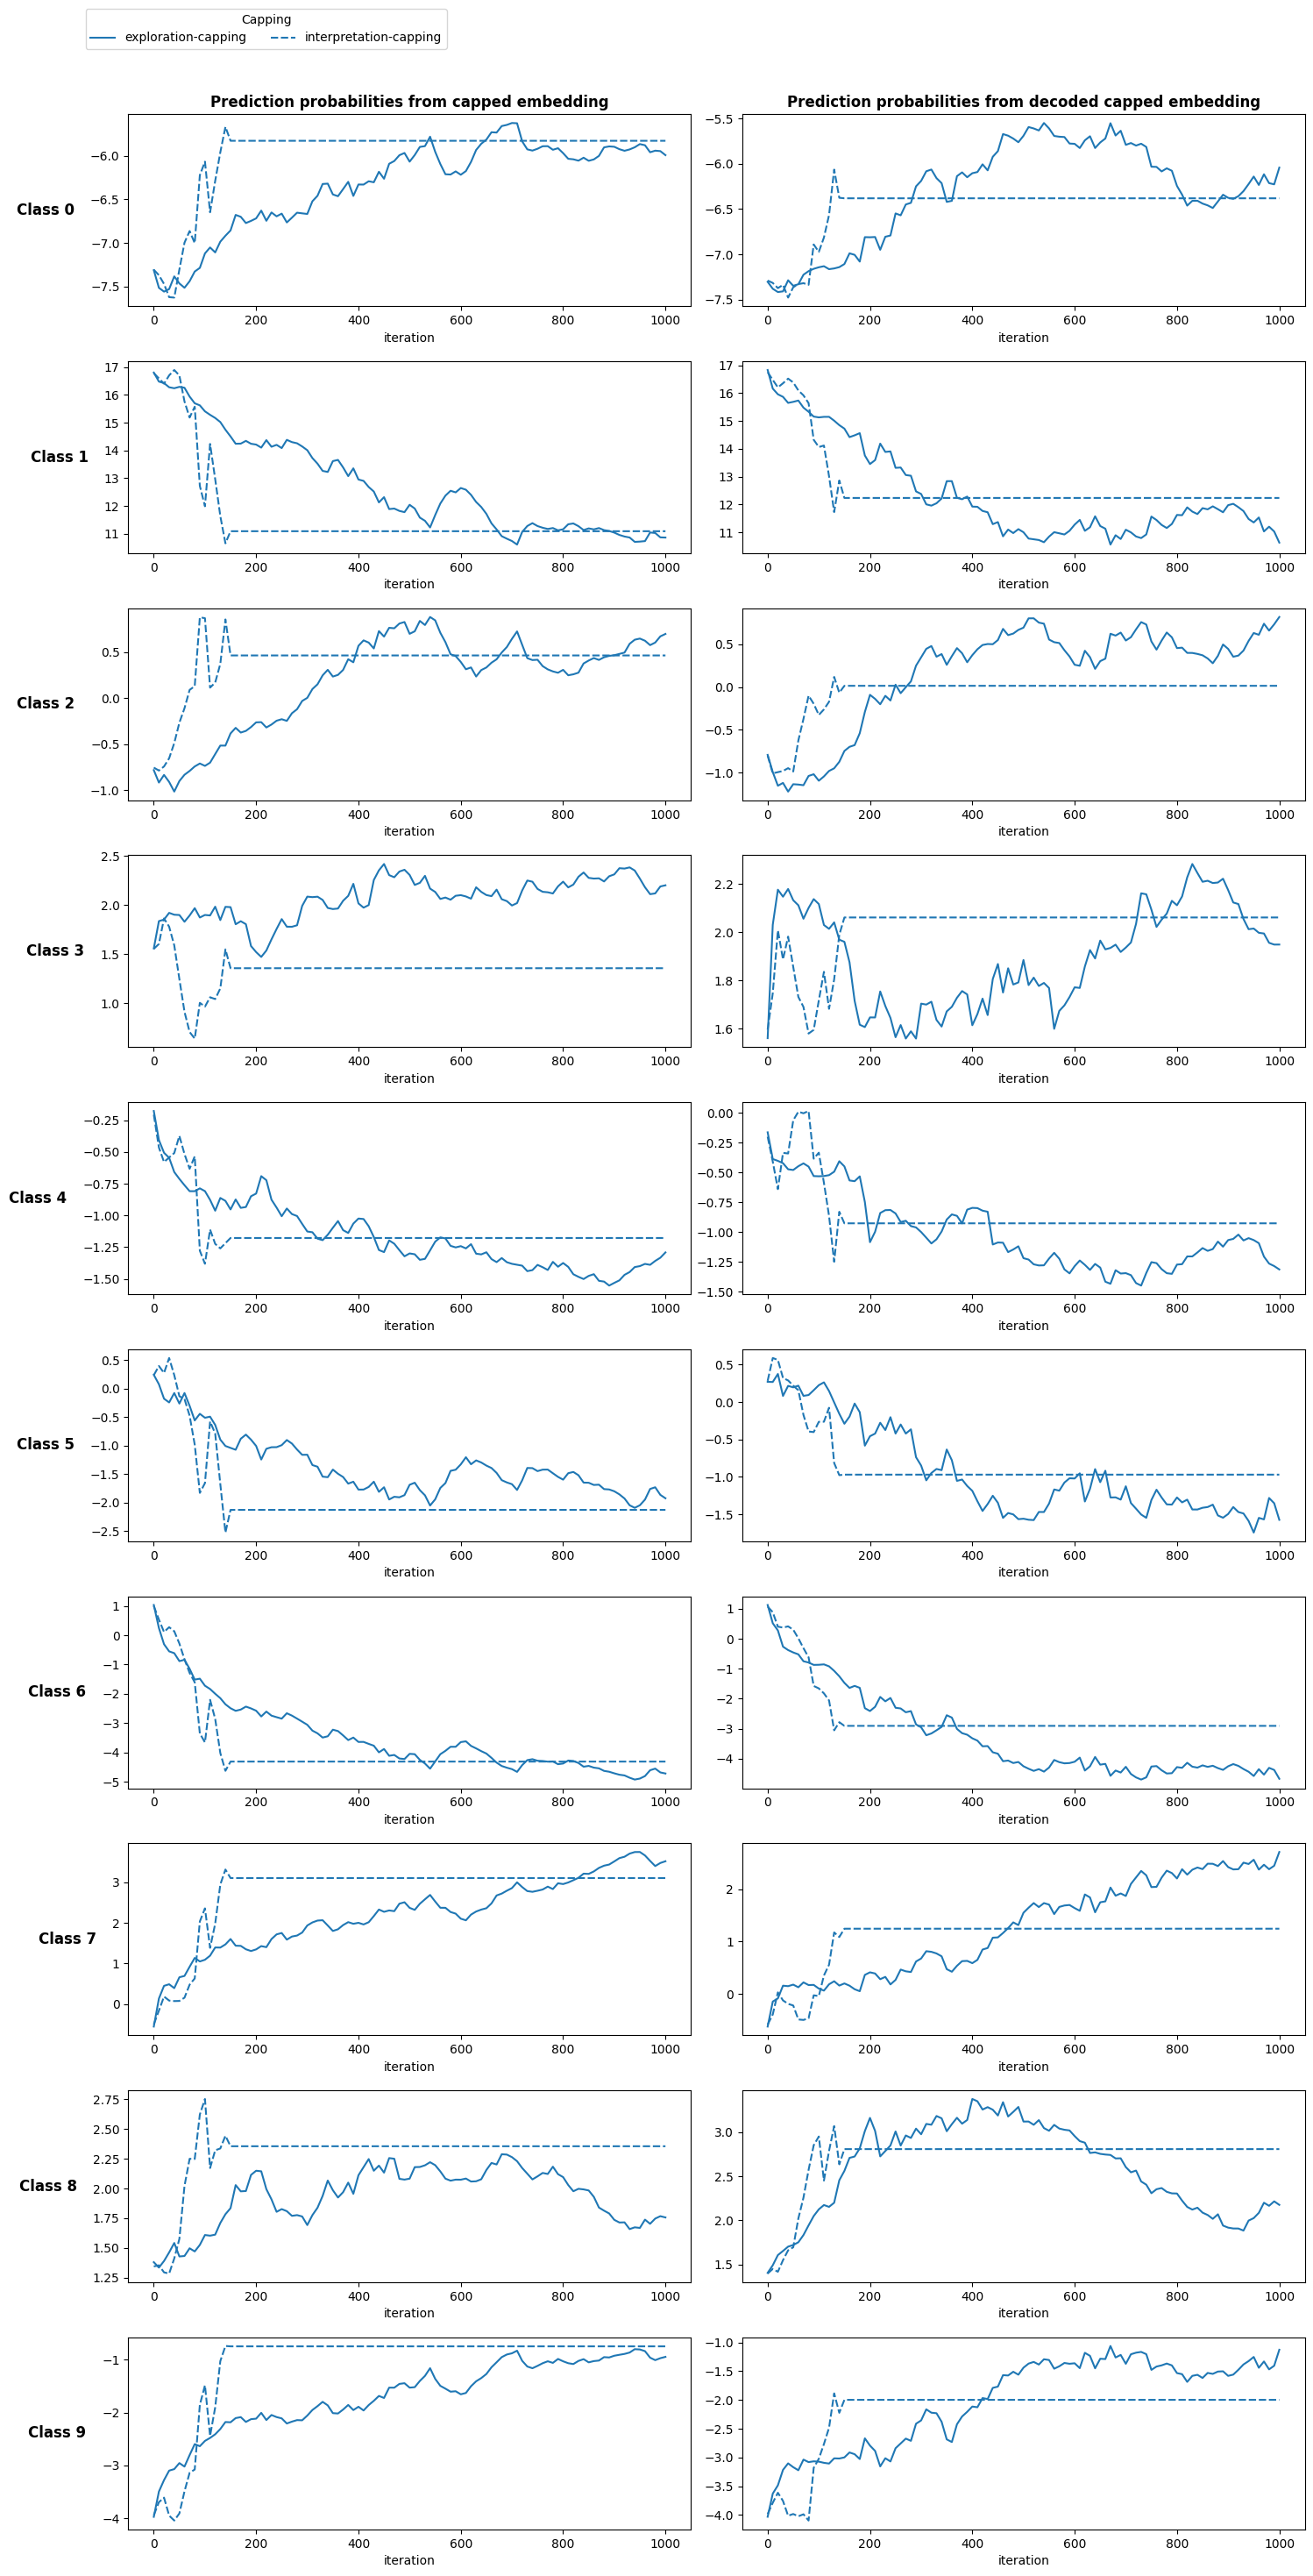

In [246]:
plot_prediction_proba_trend(features=columns, classes=list(classes), input_name="img_0")

<img src="/Users/lizzy/research/input-space-inspection/capping-experiments/res/interpretation-capping/input-space-exploration/simexp-vit-20241028-171517/img_14/interpretation/0-3-3-3.png">

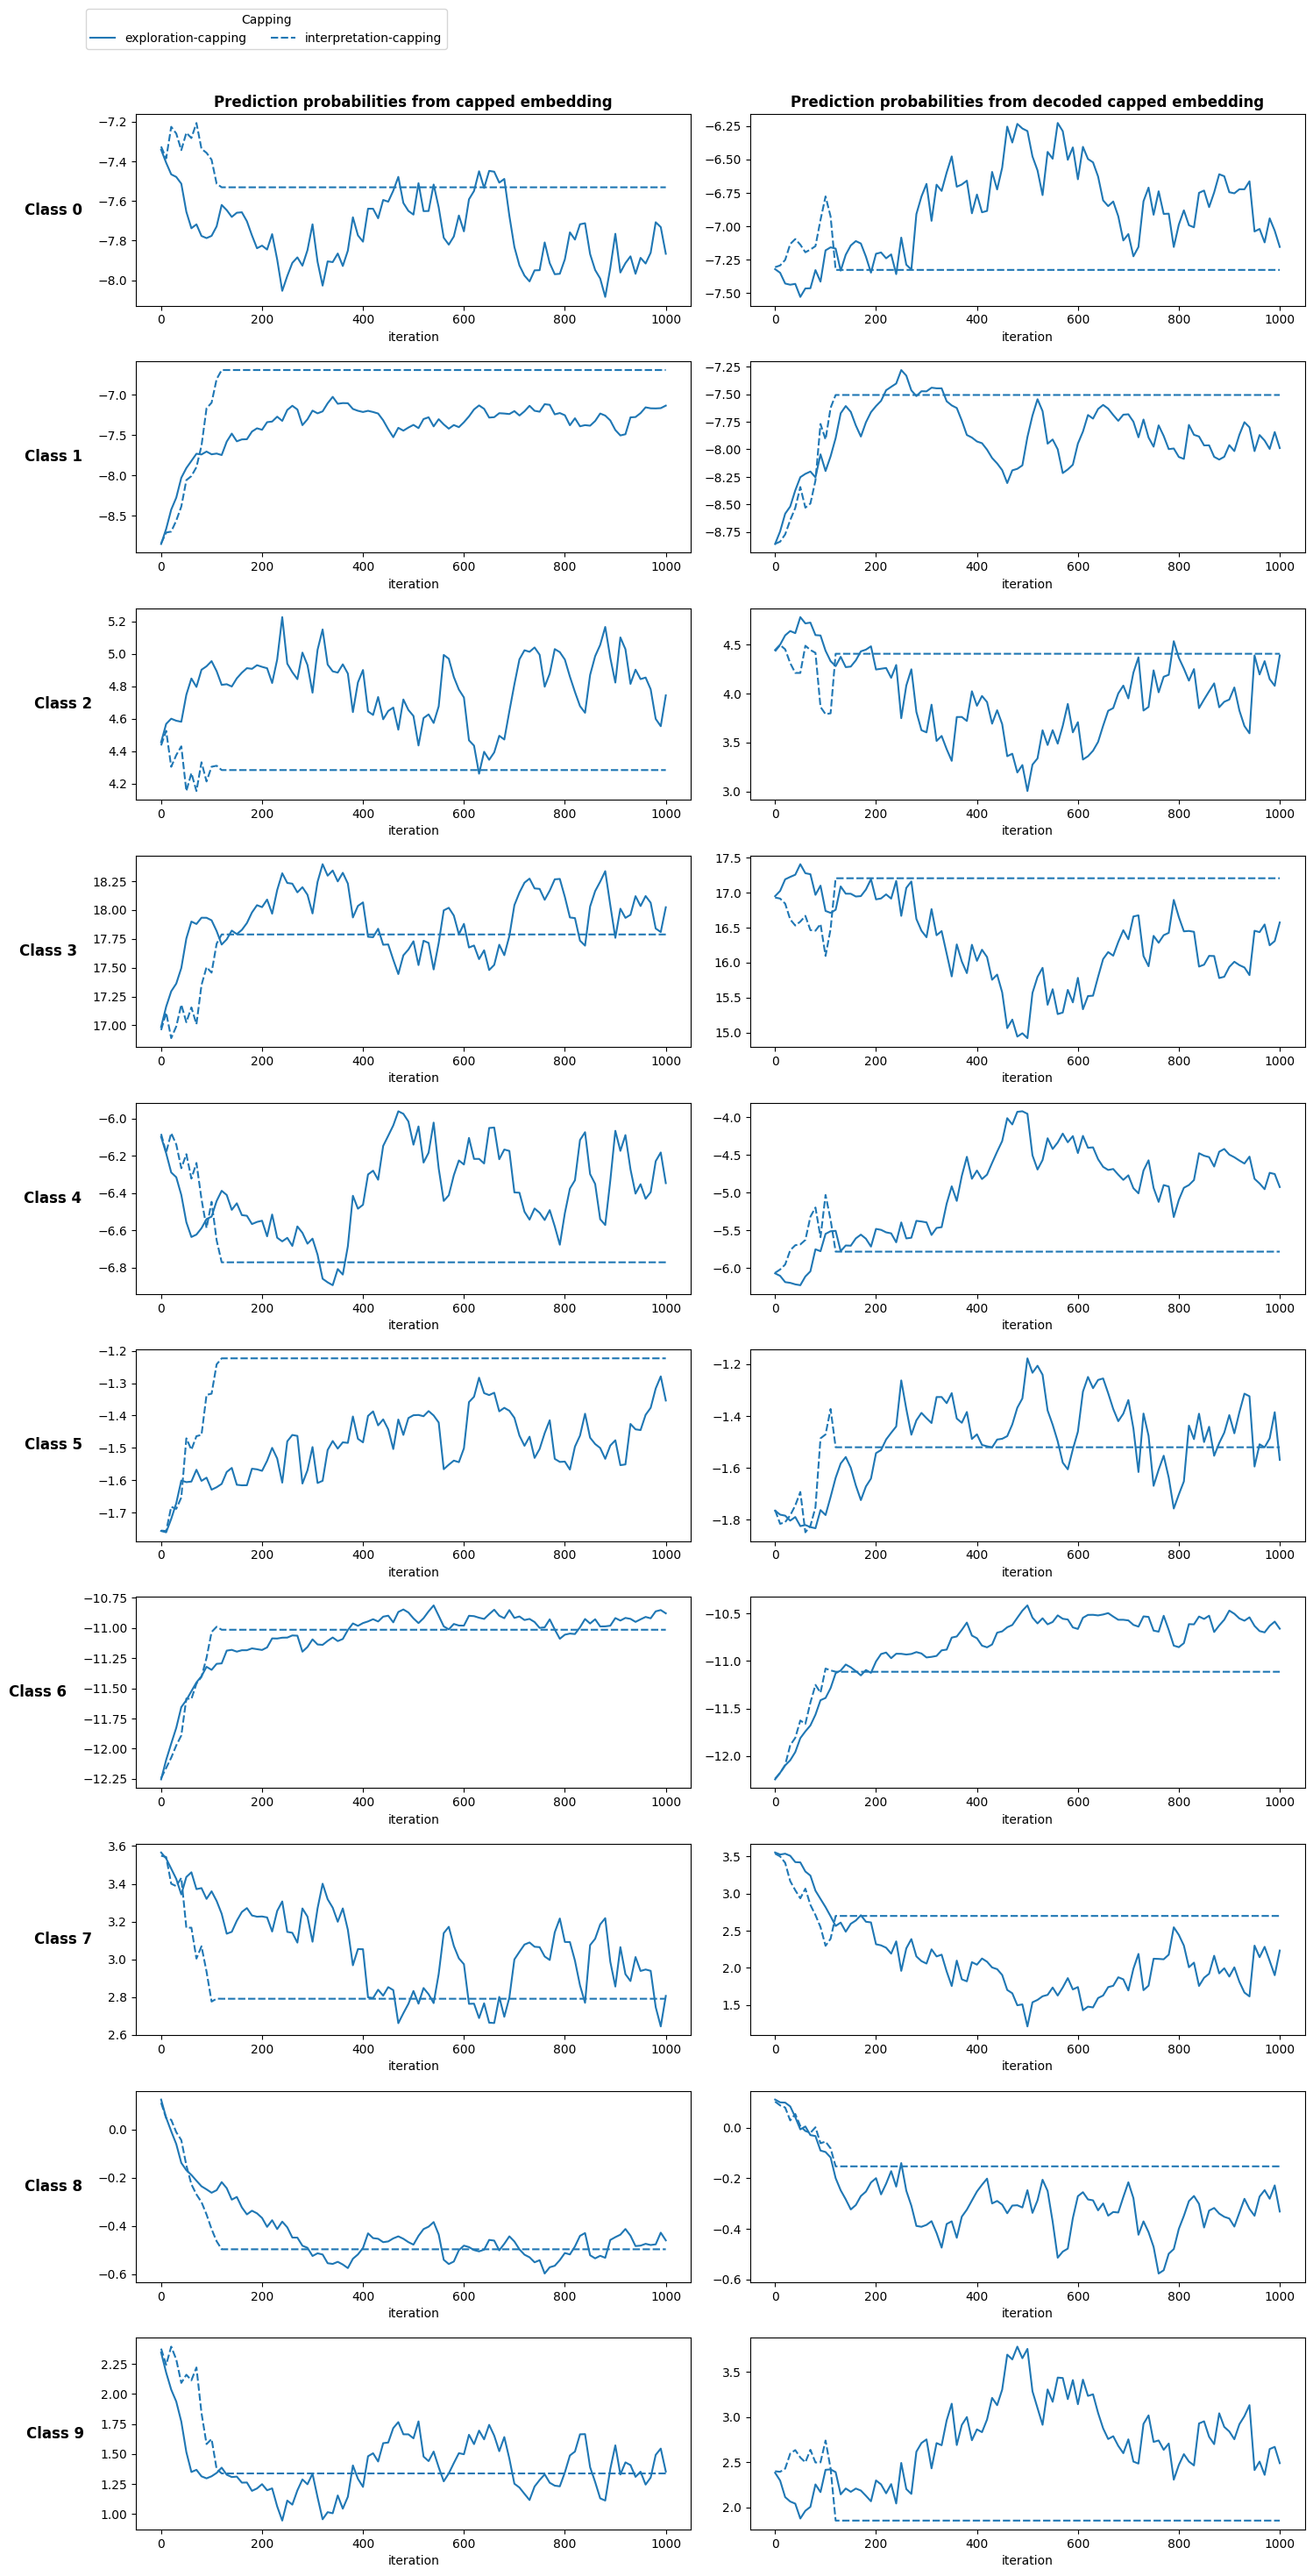

In [247]:
plot_prediction_proba_trend(
    features=columns, classes=list(classes), input_name="img_14"
)

<img src="/Users/lizzy/research/input-space-inspection/capping-experiments/res/interpretation-capping/input-space-exploration/simexp-vit-20241028-171517/img_27/interpretation/0-9-9-9.png">

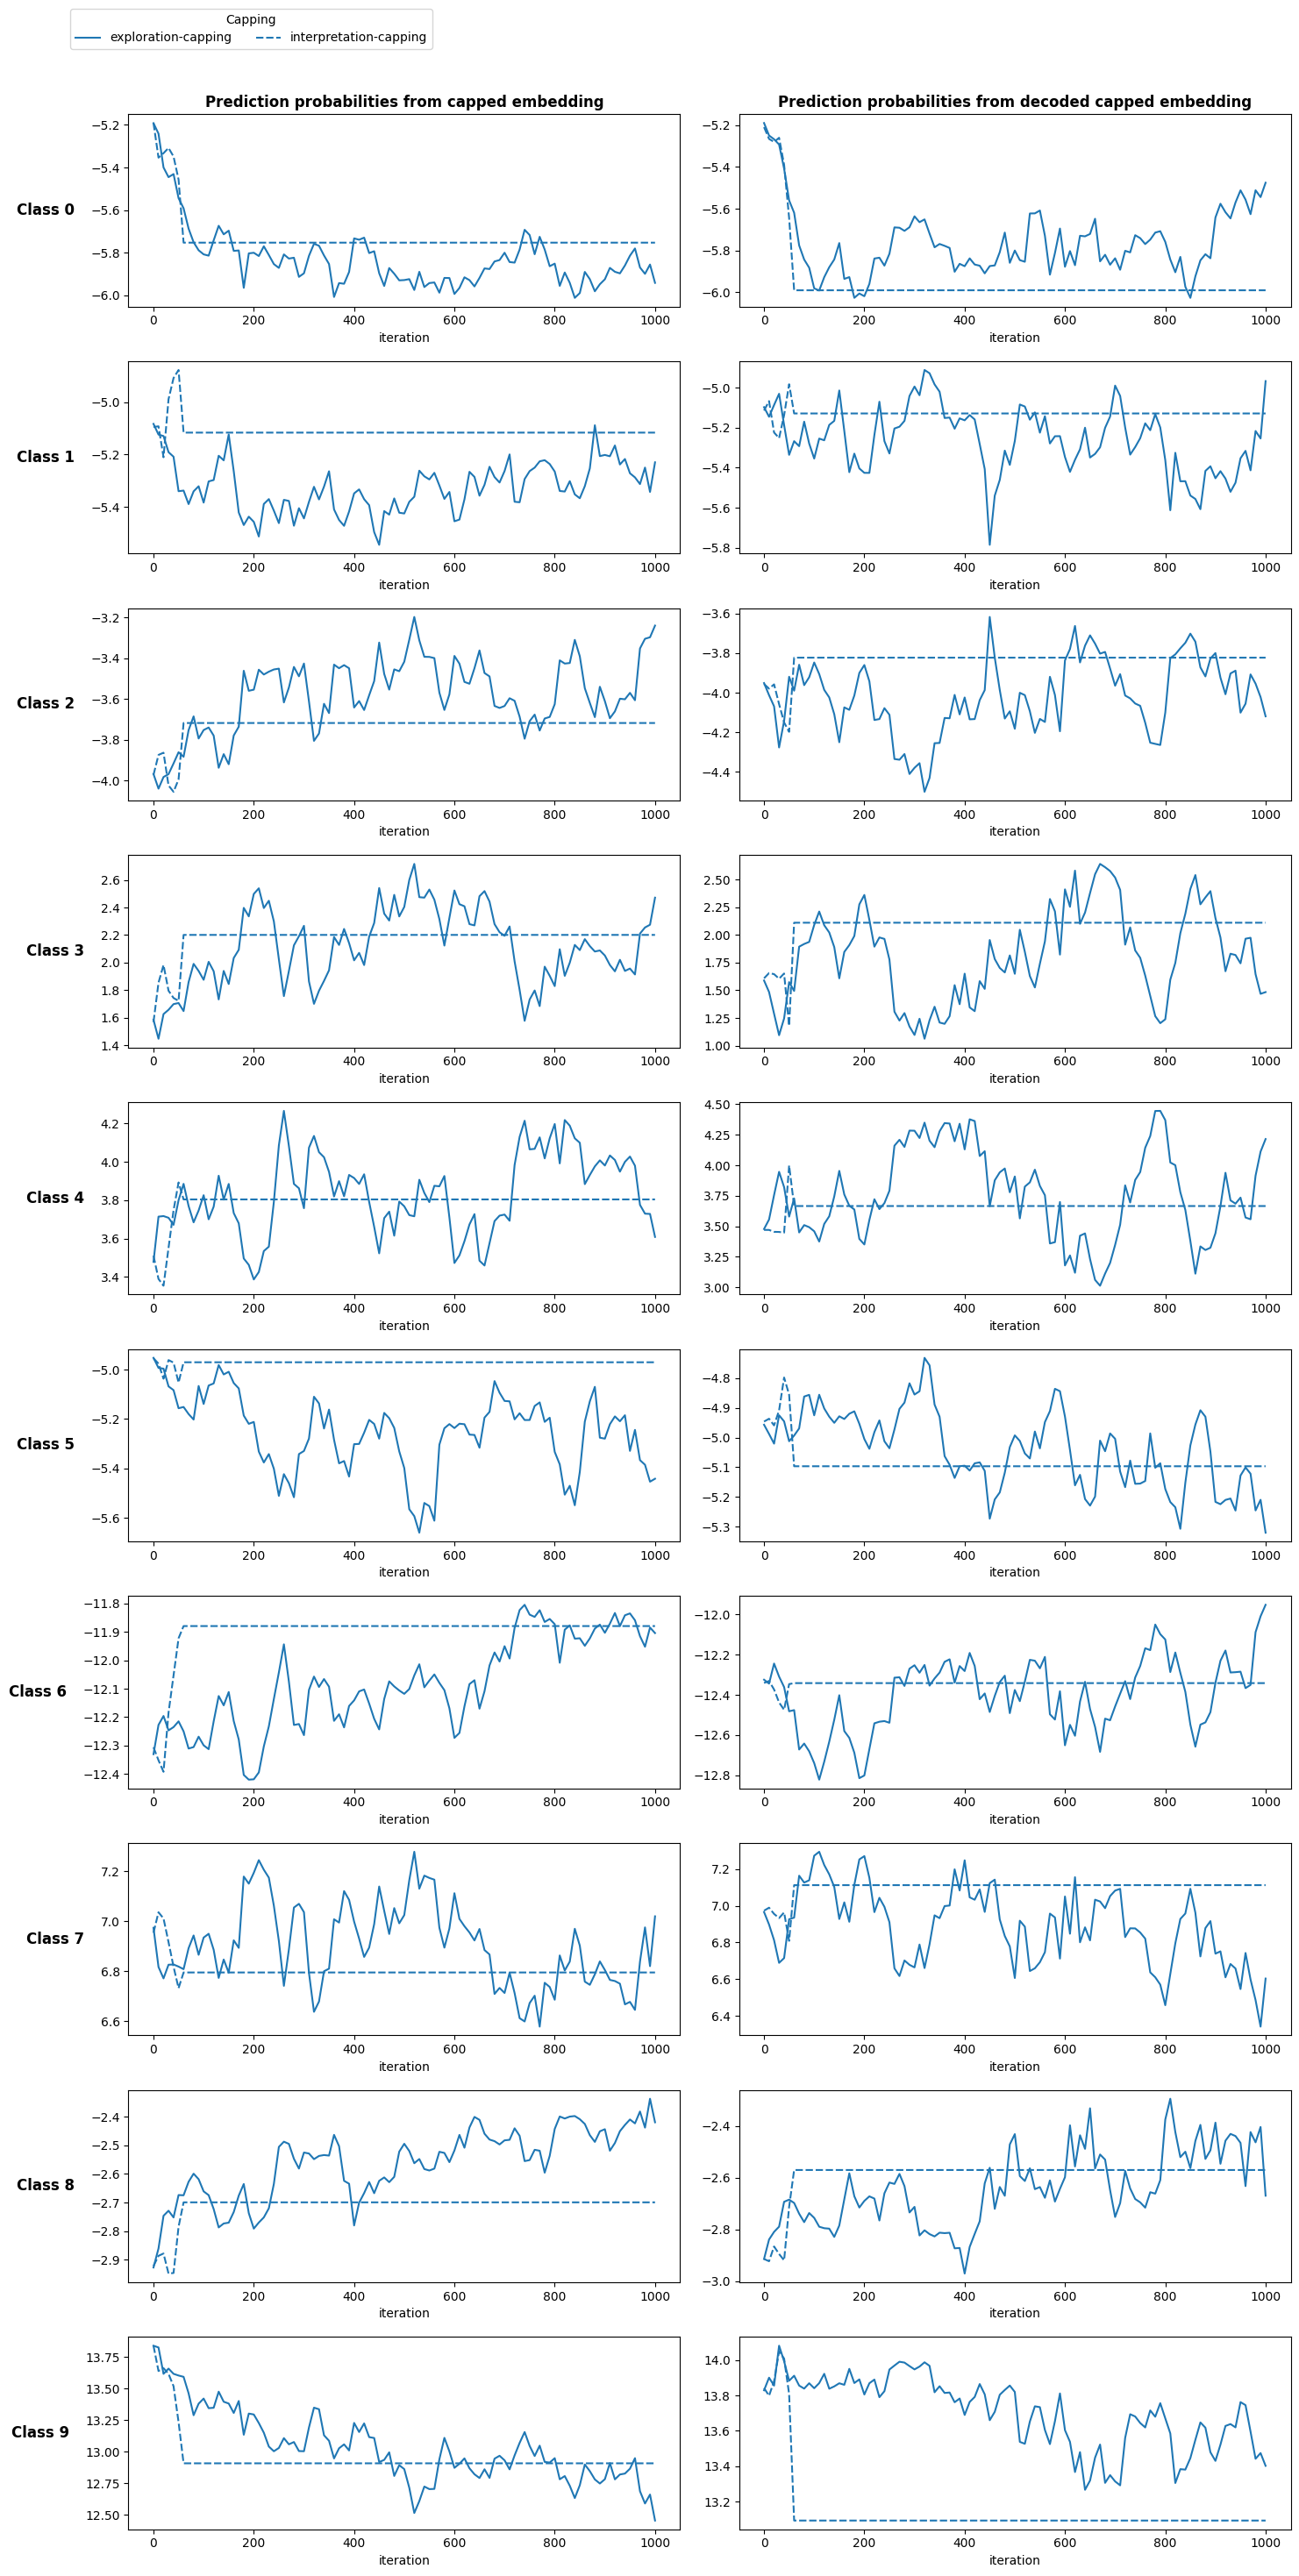

In [248]:
plot_prediction_proba_trend(
    features=columns, classes=list(classes), input_name="img_27"
)

# 3. Are there differences between capping approaches in decoded outputs?

Here I want to check how different the decoded embeddings (which cuold be texts or images) are when using a different capping approach. I should check only for those patches or tokens that are subject to update during the algorithm.

I want to show:

- difference between decoded output at each iteration, considering interpretation- and exploration- time capping approaches;
- difference in variations between decoded embedding at iteration $x$ and iteration $x-1$.

### Difference in updated patches

In [251]:
interpretation_results["updated-patches-norm"] = interpretation_results.apply(
    lambda x: np.linalg.norm(x["updated-patches"]), axis=1
)

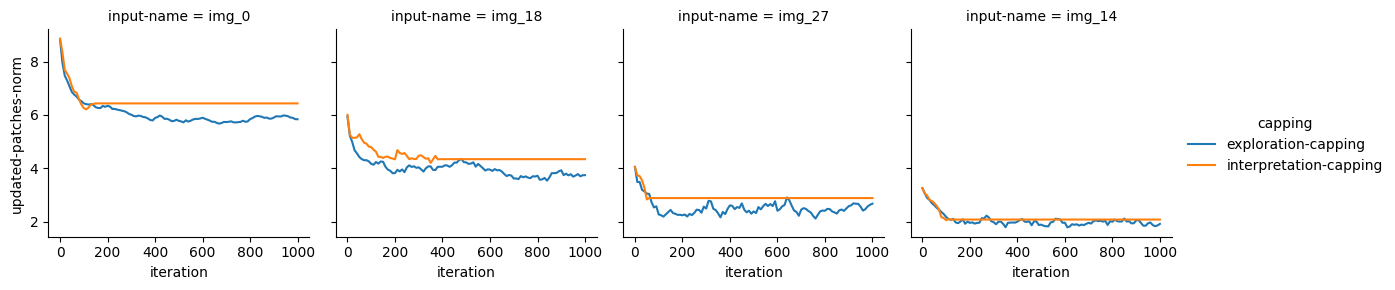

In [253]:
g = sns.FacetGrid(interpretation_results, col="input-name", hue="capping")
g.map_dataframe(sns.lineplot, x="iteration", y="updated-patches-norm")
g.add_legend()

As we can see in the previous analysis, those experiments performed with the interpretation-time capping approach results in an initial update that then stabilises. This is due to the fact that the explored embeddings do not return to the 'permissible' space, and every update results in something that is being capped in the same way at interpretation time.

### Iteration-by-iteration differences in patch updates

It is easy to see that interpretation-time capping eventually stops updating the decoded input.

dynamic time warping
fast